# Giai đoạn 5 – XGBoost (Full feature set)

Params: n_estimators=100, max_depth=6, lr=0.1, subsample=0.8, colsample_bytree=0.8.  
Acc ≈ 0.935 ± 0.020 (std thấp nhất) → ổn định.  
Có feature importance dạng gradient boosting → chọn làm ứng viên triển khai.  
So sánh: tương đương kNN về mean, tốt hơn về độ ổn định.

# Tiền xử lý ảnh
+ Cùng pipeline tiền xử lý với SVM full:
+ _prep_gray(): grayscale + downscale >700k + medianBlur(3).
+ OCR: adaptiveThreshold (21,8) + Tesseract + words clean + hybrid similarity.
+ Histogram: 32 bins / kênh, mean CORREL.
+ ORB: trực tiếp trên gray; Lowe ratio 0.75; score kết hợp ratio & quality.
+ Layout: Canny IoU.
+ Không chuẩn hóa feature (XGBoost không yêu cầu)

In [5]:
import cv2, os, re, numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
from difflib import SequenceMatcher
from xgboost import XGBClassifier  
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

def load_cases():
    mapping = {'identical':'similar','text_changes':'almost','layout_changes':'almost',
               'changes':'different','completely_different':'different'}
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label: 
                cases.append((os.path.join(ori_dir,f), os.path.join(vidir,vf), label))
                groups.append(group_id)
    return cases, groups

class FeatureXGBoost:
    def __init__(self, n_estimators=100, max_depth=6, learning_rate=0.1, 
                 subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0):
        self.model = XGBClassifier(
            n_estimators=n_estimators,      # Số trees (tương tự RF)
            max_depth=max_depth,            # Độ sâu cây
            learning_rate=learning_rate,    # Tốc độ học (unique cho boosting)
            subsample=subsample,            # Sample ratio mỗi tree
            colsample_bytree=colsample_bytree,  # Feature sampling
            reg_alpha=reg_alpha,            # L1 regularization (Lasso)
            reg_lambda=reg_lambda,          # L2 regularization (Ridge)
            random_state=42,                # Reproducible
            eval_metric='mlogloss',         # Metric cho multi-class
            verbosity=0,                    # Tắt warnings
            use_label_encoder=False         # Avoid deprecation warning
        )
        
        self.orb = cv2.ORB_create(nfeatures=150)
        self.map = {'similar':0,'almost':1,'different':2}
        self.names = ['Similar','Almost','Different']
        self._ocr_cache = {}

    def _prep_gray(self, img):
        g=cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels=700_000
        h,w=g.shape
        if h*w>max_pixels:
            s=(max_pixels/(h*w))**0.5
            g=cv2.resize(g,(int(w*s), int(h*s)))
        g=cv2.medianBlur(g,3)
        return g

    def f_ssim(self, a, b):
        try:
            g1 = self._prep_gray(a); g2 = self._prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def f_ocr(self,a,b):
        def get_words(p,gimg):
            if p in self._ocr_cache: return self._ocr_cache[p]
            bw=cv2.adaptiveThreshold(gimg,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY,21,8)
            txt=pytesseract.image_to_string(bw, config="--oem 3 --psm 6")
            ws=re.sub(r'[^A-Za-z0-9 ]+',' ',txt).lower().split()
            self._ocr_cache[p]=ws
            return ws
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            if g1 is None or g2 is None: return 0.5
            t1=get_words(a,g1); t2=get_words(b,g2)
            if len(t1)<3 and len(t2)<3: return 0.8
            if len(t1)==0 or len(t2)==0: return 0.3
            sm=SequenceMatcher(None,' '.join(t1),' '.join(t2)).ratio()
            jacc=len(set(t1)&set(t2))/max(len(set(t1)),len(set(t2)))
            return float(np.clip(0.7*sm+0.3*jacc,0.1,0.95))
        except: return 0.5

    def f_hist(self,a,b):
        try:
            c1=cv2.imread(a); c2=cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            bins=32
            sims=[]
            for ch in range(3):
                h1=cv2.calcHist([c1],[ch],None,[bins],[0,256])
                h2=cv2.calcHist([c2],[ch],None,[bins],[0,256])
                cv2.normalize(h1,h1,alpha=1.0,norm_type=cv2.NORM_L1)
                cv2.normalize(h2,h2,alpha=1.0,norm_type=cv2.NORM_L1)
                sims.append((cv2.compareHist(h1,h2,cv2.HISTCMP_CORREL)+1)/2)
            return float(np.mean(sims))
        except: return 0.5

    def f_orb(self,a,b):
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            kp1,d1=self.orb.detectAndCompute(g1,None)
            kp2,d2=self.orb.detectAndCompute(g2,None)
            if d1 is None or d2 is None: return 0.5
            bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            knn=bf.knnMatch(d1,d2,k=2)
            good=[]
            for pr in knn:
                if len(pr)<2: continue
                m,n=pr
                if m.distance<0.75*n.distance: good.append(m)
            if not good: return 0.5
            ratio=len(good)/max(1,min(len(kp1),len(kp2)))
            quality=1 - np.mean([m.distance for m in good])/256.0
            return float(np.clip(0.5*ratio+0.5*quality,0,1))
        except: return 0.5

    def f_layout(self, a, b):
        try:
            e1 = cv2.Canny(self._prep_gray(a), 50, 150) > 0
            e2 = cv2.Canny(self._prep_gray(b), 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni   = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            iou = inter / uni
            return float(iou)  
        except:
            return 0.5

    def feat(self,a,b):
        return [self.f_ssim(a,b), self.f_ocr(a,b), self.f_hist(a,b), self.f_orb(a,b), self.f_layout(a,b)]

    def train_eval(self, cases, groups):
        X = [self.feat(a,b) for a,b,l in cases]
        y = [self.map[l] for _,_,l in cases]
        
        gkf = GroupKFold(n_splits=5)  
        accuracies = []
        fold = 1
        
        print("Running XGBoost V6...")
        for train_idx, test_idx in gkf.split(X, y, groups):
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]
            
            self.model.fit(Xtr, ytr) 
            yp = self.model.predict(Xte) 

            acc = (yp==yte).mean()*100
            accuracies.append(acc)
            
            print(f"Fold {fold} - XGBoost: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"\nV6 XGBoost Results:")
        print(f"Mean Accuracy: {mean_acc:.1f}%")
        print(f"Std Accuracy: {std_acc:.1f}%")
        
        feature_names = ['SSIM', 'OCR', 'Histogram', 'ORB', 'Layout']
        importances = self.model.feature_importances_
        print(f"\n🔧 XGBoost Feature Importances:")
        for name, imp in zip(feature_names, importances):
            print(f"   {name}: {imp:.3f}")
        
        return mean_acc, std_acc

print("Testing V6 XGBoost")
cases, groups = load_cases()
print(f"Loaded: {len(cases)} cases from {len(set(groups))} groups")

default_xgb = FeatureXGBoost() 
xgb_mean, xgb_std = default_xgb.train_eval(cases, groups)

Testing V6 XGBoost
Loaded: 299 cases from 60 groups
Running XGBoost V6...
Fold 1 - XGBoost: 93.3%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       1.00      0.83      0.91        24
   Different       0.86      1.00      0.92        24

    accuracy                           0.93        60
   macro avg       0.95      0.94      0.94        60
weighted avg       0.94      0.93      0.93        60

[[12  0  0]
 [ 0 20  4]
 [ 0  0 24]]
Fold 2 - XGBoost: 91.7%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       0.91      0.88      0.89        24
   Different       0.88      0.92      0.90        24

    accuracy                           0.92        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.92      0.92      0.92        60

[[12  0  0]
 [ 0 21  3]
 [ 0  2 22]]
Fold 3 - XGBoost: 95.0%
              prec

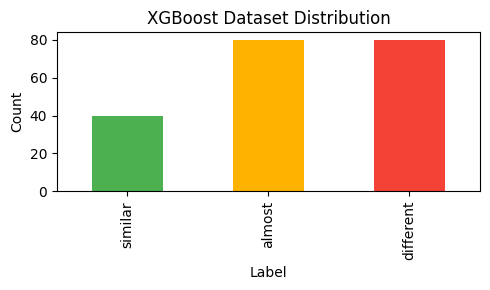

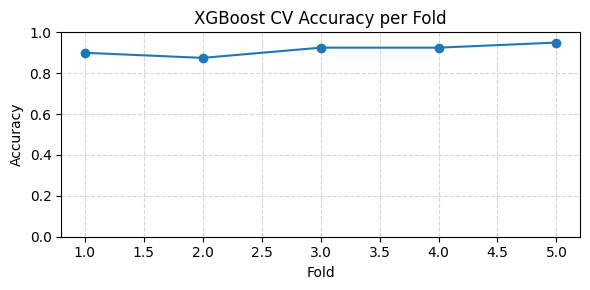

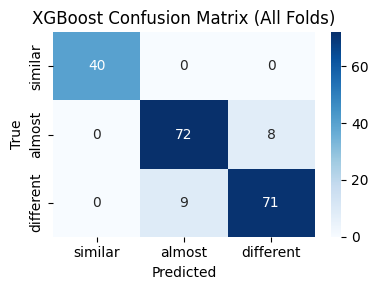

C:\Users\Thanh No\AppData\Local\Temp\ipykernel_22304\2733009451.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_cols, y=importances, palette='viridis')


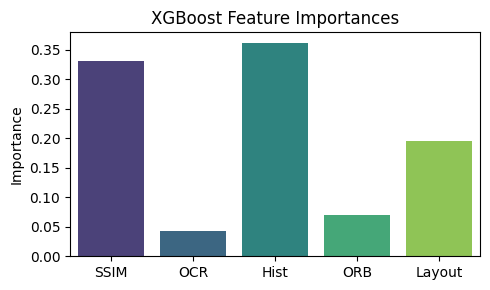

\nClassification Report (Aggregated CV):
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        40
      Almost       0.89      0.90      0.89        80
   Different       0.90      0.89      0.89        80

    accuracy                           0.92       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.92      0.92      0.91       200



In [ ]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier

def build_feature_df_xgb(model, cases, groups):
    rows=[]
    for (a,b,l), g in zip(cases, groups):
        f = model.feat(a,b)
        rows.append({'SSIM':f[0],'OCR':f[1],'Hist':f[2],'ORB':f[3],'Layout':f[4],
                     'label':l,'group':g})
    return pd.DataFrame(rows)

if 'df_xgb' not in globals():
    df_xgb = build_feature_df_xgb(default_xgb, cases, groups)

label_order = ['similar','almost','different']
feat_cols = ['SSIM','OCR','Hist','ORB','Layout']
inv_map = {v:k for k,v in default_xgb.map.items()}

plt.figure(figsize=(5,3))
df_xgb['label'].value_counts().reindex(label_order).plot(kind='bar',
    color=['#4caf50','#ffb300','#f44336'])
plt.title('XGBoost Dataset Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

gkf = GroupKFold(n_splits=5)
X_all = df_xgb[feat_cols].values
y_all = df_xgb['label'].values
accs=[]; all_true=[]; all_pred=[]

for fold,(tr,te) in enumerate(gkf.split(X_all, y_all, groups),1):
    Xtr,Xte = X_all[tr], X_all[te]
    ytr,yte = y_all[tr], y_all[te]
    model_fold = XGBClassifier(
        n_estimators=default_xgb.model.get_params()['n_estimators'],
        max_depth=default_xgb.model.get_params()['max_depth'],
        learning_rate=default_xgb.model.get_params()['learning_rate'],
        subsample=default_xgb.model.get_params()['subsample'],
        colsample_bytree=default_xgb.model.get_params()['colsample_bytree'],
        reg_alpha=default_xgb.model.get_params()['reg_alpha'],
        reg_lambda=default_xgb.model.get_params()['reg_lambda'],
        random_state=42,
        eval_metric='mlogloss',
        verbosity=0,
        use_label_encoder=False
    )
    ytr_int = [default_xgb.map[l] for l in ytr]
    model_fold.fit(Xtr, ytr_int)
    yp_int = model_fold.predict(Xte)
    yp = [inv_map[i] for i in yp_int]
    accs.append(accuracy_score(yte, yp))
    all_true.extend(yte); all_pred.extend(yp)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.title('XGBoost CV Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid(ls='--',alpha=.5)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=label_order)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.title('XGBoost Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

full_xgb = XGBClassifier(
    n_estimators=default_xgb.model.get_params()['n_estimators'],
    max_depth=default_xgb.model.get_params()['max_depth'],
    learning_rate=default_xgb.model.get_params()['learning_rate'],
    subsample=default_xgb.model.get_params()['subsample'],
    colsample_bytree=default_xgb.model.get_params()['colsample_bytree'],
    reg_alpha=default_xgb.model.get_params()['reg_alpha'],
    reg_lambda=default_xgb.model.get_params()['reg_lambda'],
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0,
    use_label_encoder=False
)
full_xgb.fit(X_all, [default_xgb.map[l] for l in y_all])
importances = full_xgb.feature_importances_
plt.figure(figsize=(5,3))
sns.barplot(x=feat_cols, y=importances, palette='viridis')
plt.title('XGBoost Feature Importances')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print('\\nClassification Report (Aggregated CV):')
print(classification_report(all_true, all_pred, labels=label_order, target_names=['Similar','Almost','Different']))

In [3]:
# def tune_xgb_v6_comprehensive():
#     """Comprehensive XGBoost tuning với GroupKFold"""
#     print("XGBOOST PARAMETER TUNING (V6)")
#     print("="*50)
    
#     cases, groups = load_cases()
    
#     class FeatureXGBTuned(FeatureXGBoost):
#         def __init__(self, n_estimators=100, max_depth=6, learning_rate=0.1, 
#                      subsample=0.8, colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0):
#             # Call parent constructor với custom parameters
#             super().__init__(n_estimators, max_depth, learning_rate, subsample, colsample_bytree)
            
#             # Override với full parameter set
#             self.model = XGBClassifier(
#                 n_estimators=n_estimators,
#                 max_depth=max_depth,
#                 learning_rate=learning_rate,
#                 subsample=subsample,
#                 colsample_bytree=colsample_bytree,
#                 reg_alpha=reg_alpha,        # L1 regularization
#                 reg_lambda=reg_lambda,      # L2 regularization
#                 random_state=42,
#                 eval_metric='mlogloss',
#                 verbosity=0,
#                 use_label_encoder=False
#             )
    
#     param_combinations = [
#         # Core parameter variations
#         {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},  # Default baseline
#         {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1},
#         {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1},
        
#         # Learning rate variations
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.05},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.3},
        
#         # Depth variations
#         {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
#         {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1},
#         {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1},
        
#         # Sampling variations
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.7},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.9},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.7},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0},
        
#         # Regularization variations  
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 0.1},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'reg_lambda': 0.5},
#         {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.5},
        
#         # High performance combinations
#         {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8},
#         {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9},
#     ]
    
#     best_score = 0
#     best_params = {}
#     all_results = []
    
#     for i, params in enumerate(param_combinations, 1):
#         print(f"\nTesting {i}/{len(param_combinations)}: {params}")
        
#         try:
#             # Fill in default values for missing parameters
#             full_params = {
#                 'n_estimators': 100,
#                 'max_depth': 6, 
#                 'learning_rate': 0.1,
#                 'subsample': 0.8,
#                 'colsample_bytree': 0.8,
#                 'reg_alpha': 0.0,
#                 'reg_lambda': 1.0
#             }
#             full_params.update(params)
            
#             model = FeatureXGBTuned(**full_params)
#             X = [model.feat(a,b) for a,b,l in cases]
#             y = [model.map[l] for _,_,l in cases]
            
#             gkf = GroupKFold(n_splits=3)  # 3 splits for speed
#             scores = []
            
#             for train_idx, test_idx in gkf.split(X, y, groups):
#                 Xtr = [X[i] for i in train_idx]
#                 ytr = [y[i] for i in train_idx]
#                 Xte = [X[i] for i in test_idx]
#                 yte = [y[i] for i in test_idx]
                
#                 # XGBoost training - no scaling needed
#                 model.model.fit(Xtr, ytr)
#                 yp = model.model.predict(Xte)
                
#                 scores.append((yp == yte).mean())
            
#             avg_score = np.mean(scores)
#             std_score = np.std(scores)
            
#             all_results.append({
#                 'params': full_params,
#                 'score': avg_score,
#                 'std': std_score
#             })
            
#             if avg_score > best_score:
#                 best_score = avg_score
#                 best_params = full_params
            
#             print(f"   Score: {avg_score*100:.1f}% ± {std_score*100:.1f}%")
            
#             # Show feature importance for best models
#             if avg_score >= 0.94:  # Show importance for top models
#                 feature_names = ['SSIM', 'OCR', 'Histogram', 'ORB', 'Layout']
#                 importances = model.model.feature_importances_
#                 print(f"   Feature Importance: {dict(zip(feature_names, [f'{imp:.3f}' for imp in importances]))}")
        
#         except Exception as e:
#             print(f"   ERROR: {str(e)[:50]}...")
#             continue
    
#     # Results summary
#     print(f"\nBEST XGBOOST CONFIG:")
#     print(f"   Parameters: {best_params}")
#     print(f"   CV Accuracy: {best_score*100:.1f}%")
    
#     # Top 5 results
#     print(f"\nTOP 5 CONFIGURATIONS:")
#     top_results = sorted(all_results, key=lambda x: x['score'], reverse=True)[:5]
#     for i, result in enumerate(top_results, 1):
#         params_str = {k: v for k, v in result['params'].items() if k in ['n_estimators', 'max_depth', 'learning_rate']}
#         print(f"   {i}. {result['score']*100:.1f}% ± {result['std']*100:.1f}% | {params_str}")
    
#     # Compare with SVM baseline
#     svm_baseline = 94.0  # From V3 results
#     improvement = (best_score * 100) - svm_baseline
#     print(f"\nCOMPARISON WITH SVM V3:")
#     print(f"   SVM Best (V3):     {svm_baseline:.1f}%")
#     print(f"   XGBoost Best (V6): {best_score*100:.1f}%")
#     print(f"   Improvement:       {improvement:+.1f}%")
    
#     return best_params, all_results

# # Run comprehensive tuning
# best_xgb_params, xgb_results = tune_xgb_v6_comprehensive()